### Import the Libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
import seaborn as sns

Using TensorFlow backend.


### Directories

In [2]:
train_directory = 'D:\Data for machine learning\Sartorius cell instance segmentation\LIVECell_dataset_2021\images\livecell_train_val_images'
test_directory = 'D:\Data for machine learning\Sartorius cell instance segmentation\LIVECell_dataset_2021\images\livecell_test_images'

### Image Parameters

In [3]:
target_size = (100, 100)

### Data Collection

In [4]:
img_dataset, img_labels = [], []

def load_images(directory, img_dataset, img_labels):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".tif"):
                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                image = cv2.resize(image, target_size)
                label = os.path.basename(os.path.dirname(image_path))
                img_dataset.append(image.astype('float32'))
                img_labels.append(label)

### Load Images

In [5]:
load_images(train_directory, img_dataset, img_labels)
load_images(test_directory, img_dataset, img_labels)

### Convert to numpy arrays

In [6]:
X, L = np.asarray(img_dataset), np.asarray(img_labels)

### Encoding

In [7]:
class_labels = ['A172', 'BT474', 'BV2', 'Huh7', 'MCF7', 'RatC6', 'SHSY5Y', 'SkBr3', 'SKOV3']
label_map = {class_label: i for i, class_label in enumerate(class_labels)}
L = to_categorical(np.vectorize(label_map.get)(L), num_classes=len(class_labels))

### Image Data Format Handling

In [8]:
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    input_shape = (1, X.shape[1], X.shape[2])
else:
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    input_shape = (X.shape[1], X.shape[2], 1)

### Data Preprocessing/Normalization

In [9]:
X = (X - X.mean()) / (X.std())

### Data Split

In [10]:
X_train, X_test, L_train, L_test = train_test_split(X, L, test_size=0.1, random_state=4)

### Model Definition

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

### Model Compilation

In [12]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Model Summary

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)      

### Callbacks

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr *= 0.9
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

### Model Training

In [15]:
history = model.fit(X_train, L_train, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping, lr_callback])

Train on 4736 samples, validate on 527 samples
Epoch 1/50
4736/4736 [==============================] - 34s 7ms/step - loss: 2.0619 - accuracy: 0.2546 - val_loss: 1.4459 - val_accuracy: 0.5806
Epoch 2/50
4736/4736 [==============================] - 28s 6ms/step - loss: 1.2803 - accuracy: 0.5760 - val_loss: 0.8354 - val_accuracy: 0.7780
Epoch 3/50
4736/4736 [==============================] - 29s 6ms/step - loss: 0.8417 - accuracy: 0.7610 - val_loss: 0.6802 - val_accuracy: 0.8178
Epoch 4/50
4736/4736 [==============================] - 29s 6ms/step - loss: 0.6312 - accuracy: 0.8461 - val_loss: 0.5113 - val_accuracy: 0.9032
Epoch 5/50
4736/4736 [==============================] - 29s 6ms/step - loss: 0.5412 - accuracy: 0.8775 - val_loss: 0.7105 - val_accuracy: 0.8065
Epoch 6/50
4736/4736 [==============================] - 29s 6ms/step - loss: 0.5146 - accuracy: 0.8925 - val_loss: 0.4287 - val_accuracy: 0.9184
Epoch 7/50
4736/4736 [==============================] - 29s 6ms/step - loss: 0.4089

### Model Evaluation

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, L_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

585/585 [==============================] - 2s 3ms/step
Test Loss: 0.27984328374393985
Test Accuracy: 0.9692307710647583


### Plot Loss

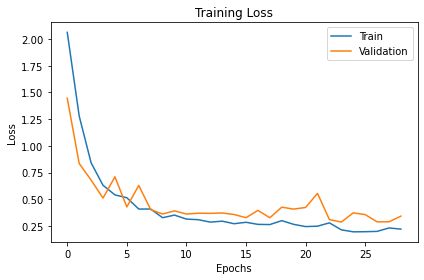

In [22]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_plot.png', dpi=300, facecolor='white')
plt.show()

### Plot Accuracy

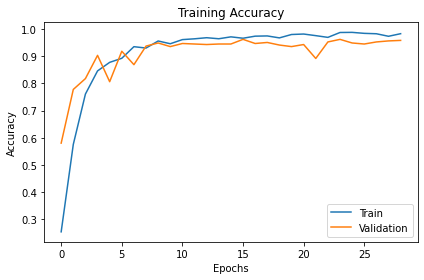

In [23]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_plot.png', dpi=300, facecolor='white')

### Confusion Matrix

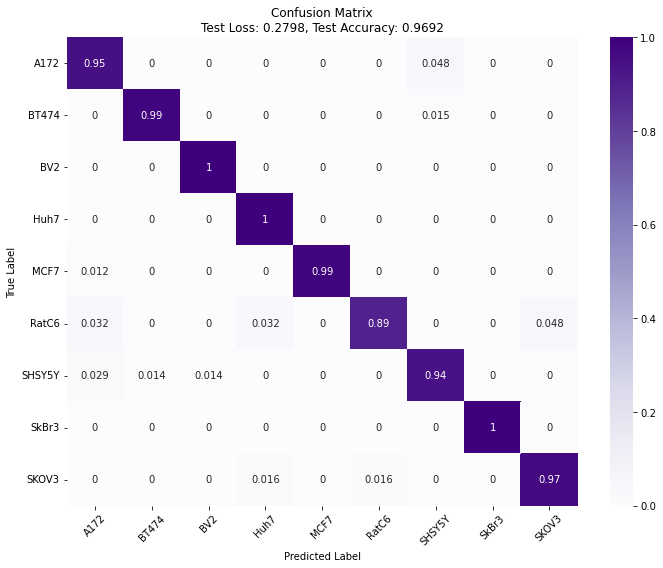

In [24]:
def plot_confusion_matrix(y_true, y_pred, class_names, test_loss, test_accuracy):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Purples', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix\nTest Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, facecolor='white')

# Predicting classes for test data
predictions = model.predict(X_test)
y_true = np.argmax(L_test, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Plotting Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_labels, test_loss, test_accuracy)

### Saving the Trained Model

In [25]:
model_json = model.to_json()
json_file = open("sartorius_9classes_model.json", "w")
json_file.write(model_json)   
model.save_weights("sartorius_9classes_model_weights.h5")
json_file.close()

print("Model saved successfully to the script's directory ;)!")

Model saved successfully to the script's directory ;)!
